# Edinburgh bike counter

Arjan Geers

Analysis of [Edinburgh bike counter data](http://www.edinburghopendata.info/dataset/bike-counter-data-set-cluster).

## Preamble

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [26]:
import pandas as pd
pd.set_option('display.max_rows', 10)

from bikecounter.data import get_edinburgh_bike_counter_data

## Get data

In [24]:
data = get_edinburgh_bike_counter_data()

In [27]:
data

,01peffermillroad,02steadfastgate,03hawkhillavenue,04seafieldstreet,05blackhall,06silverknowes,07westercoates,08forthroadbridge,09queensferrydalmeny,10rbsgogar,...,39bruntsfieldplacesouthside,40mayfieldroadnorthbound,41mayfieldroadsouthbound,42melvilledrivemain,43melvilledrivespur,44melvilledrivebus1southbound,45melvilledrivebus2northbound,46fishwivescauseway,47inverleithpark,48creweroadsouth
2007-03-29 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-29 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-18 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,9.0,8.0,47.0,38.0,13.0,10.0,6.0,13.0,5.0
2016-06-18 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,4.0,4.0,50.0,30.0,9.0,11.0,5.0,6.0,4.0
2016-06-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,2.0,32.0,26.0,7.0,3.0,3.0,2.0,4.0
2016-06-18 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,0.0,24.0,15.0,7.0,5.0,3.0,4.0,1.0


## Bike counter activity

Total number of active bike counters per month.

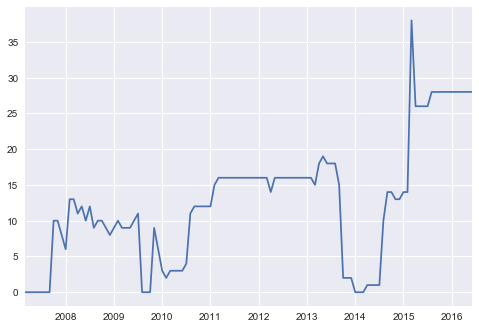

In [5]:
monthly = data.resample('M').sum()
monthly.where(monthly > 0.0).count(axis=1).plot();

Number of bikes per month for each bike counter. It appears that:
1. There are two periods in which few counters were active
2. A different set of counters was active from early 2015 onward than before

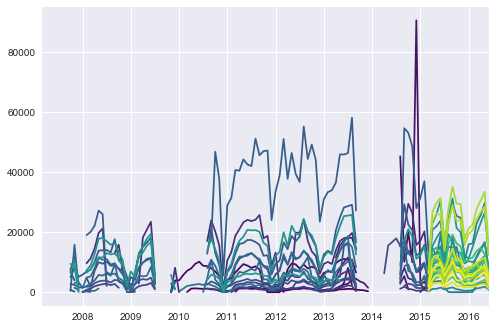

In [88]:
monthly.where(monthly > 0.0).plot(colormap='viridis', legend=False);

Date ranges of bike counter activity.

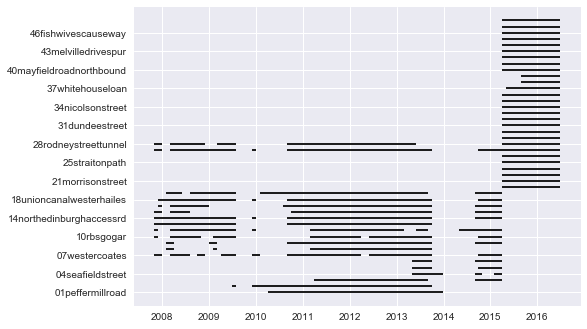

In [89]:
for street_counter, street in enumerate(monthly.columns):
    active_months = monthly[street].where(monthly[street] > 0).dropna().index
    for i in range(0, len(active_months)-1):
        if active_months[i+1].to_period('M') - active_months[i].to_period('M') == 1:
            # Draw hline for each consecutive pair of active months
            plt.hlines(street_counter,
                       active_months[i],
                       active_months[i+1])
plt.yticks(range(0, len(monthly.columns), 3), monthly.columns[::3]);